#1. Load the data

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/click/data"

 click_id.csv		 sub_lgb.csv	       train.csv
'Copy of sub_lgb.csv'	 test.csv	       train_sample.csv
 sample_submission.csv	 test_supplement.csv   Untitled0.ipynb


In [0]:
import gc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' # note that click_id is only in test data, not training data
        }

In [0]:
train = pd.read_csv('/content/drive/My Drive/click/data/train.csv',  nrows=2000000, parse_dates=['click_time'], 
                    usecols=['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed'],
                    dtype=dtypes)
test = pd.read_csv('/content/drive/My Drive/click/data/test.csv', parse_dates=['click_time'], 
                       usecols=['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id'],
                      dtype=dtypes)

# 2. Feature Engineering

In [0]:
def datetimefeatures(df):
  df['click_time'] = pd.to_datetime(df['click_time'])
  df['hour'] = df['click_time'].dt.hour.astype('uint16')
  df['minute'] = df['click_time'].dt.minute.astype('uint16')
  df['second'] = df['click_time'].dt.second.astype('uint16')
  df['day'] = df['click_time'].dt.day.astype('uint16')
  df['weekday'] = df['click_time'].dt.weekday.astype('uint16')
  df['dayofyear'] = df['click_time'].dt.dayofyear.astype('uint16')
  df['month'] = df['click_time'].dt.month.astype('uint16')
  return df

train = datetimefeatures(train)
test = datetimefeatures(test)

print(train.shape)

(2000000, 14)


In [0]:
def clickhistory(df):
  click_history ={

      'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
      'app_clicks': ['ip', 'app']
  }

  for c, s in click_history.items():
     # Clicks in the past
      df['prev_'+c] = df. \
          groupby(s). \
          cumcount(). \
          rename('prev_'+c)

      # Clicks in the future
      df['future_'+c] = df.iloc[::-1]. \
          groupby(s). \
          cumcount(). \
          rename('future_'+c).iloc[::-1]
      return df
    
train = clickhistory(train)
test = clickhistory(test)

print(train.shape)

(2000000, 16)


In [0]:
group = [
    # Count Features
    ############################################################
    
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
     # Count, for ip-app-device
    {'groupby': ['ip', 'app', 'device'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-device-day-hour
    {'groupby': ['ip','app', 'device', 'day','hour'], 'select': 'channel', 'agg': 'count'},
    # Popularity of app / channel 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    ############################################################
    
    # Variance Features
    ############################################################
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in day, for ip-app-device
    {'groupby': ['ip','app','device'], 'select': 'day', 'agg': 'var'},
    # Variance in day, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'day', 'agg': 'var'},
    ############################################################
    
    # Mean Features
    ############################################################
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    ############################################################
    
    # Nunique Features
    ############################################################
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    ############################################################
    
    # Cumcount Features
    ############################################################
    #'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount', 'type': 'uint32'}, 
    #{'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount', 'type': 'uint32'}
    ############################################################
    
]

# Apply all the groupby transformations
for spec in group:
    print(f"Grouping by {spec['groupby']}, and aggregating {spec['select']} with {spec['agg']}")
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), spec['agg'], spec['select'])
    # Perform the groupby
    gp = test[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
     # Merge back to X_train
    #train = train.merge(gp, on=spec['groupby'], how='left')
    test = test.merge(gp, on=spec['groupby'], how='left')
del gp
gc.collect()
print("End")

Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'device'], and aggregating channel with count
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'device', 'day', 'hour'], and aggregating channel with count
Grouping by ['app'], and aggregating channel with count


In [0]:
def groupby(df):
    group = [
        # Count Features
        ############################################################
        # 
        # Count, for ip-app
        {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count', 'type': 'uint16'},
        # Count, for ip-app-os
        {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count', 'type': 'uint16'},
         # Count, for ip-app-device
        {'groupby': ['ip', 'app', 'device'], 'select': 'channel', 'agg': 'count', 'type': 'uint16'},
        # Count, for ip-day-hour
        {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count','type': 'uint16'},
        # Count, for ip-app-day-hour
        {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count', 'type': 'uint16'},
        # Count, for ip-app-device-day-hour
        {'groupby': ['ip','app', 'device', 'day','hour'], 'select': 'channel', 'agg': 'count', 'type': 'uint16'},
        # Popularity of app / channel 
        {'groupby': ['app'], 'select': 'channel', 'agg': 'count', 'type': 'uint16'},
        {'groupby': ['channel'], 'select': 'app', 'agg': 'count', 'type': 'uint16'},
        ############################################################

        # Variance Features
        ############################################################
        # Variance in day, for ip-app-channel
        {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var', 'type': 'float32'},
        # Variance in day, for ip-app-device
        {'groupby': ['ip','app','device'], 'select': 'day', 'agg': 'var', 'type': 'float32'},
        # Variance in day, for ip-app-os
        {'groupby': ['ip','app','os'], 'select': 'day', 'agg': 'var', 'type': 'float32'},
        ############################################################

        # Mean Features
        ############################################################
        # Mean hour, for ip-app-channel
        {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean', 'type': 'uint16'}, 
        ############################################################

        # Nunique Features
        ############################################################
        {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique', 'type': 'uint16'}, 
        {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique', 'type': 'uint16'}, 
        {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique', 'type': 'uint16'}, 
        {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique', 'type': 'uint16'}, 
        {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique', 'type': 'uint16'}, 
        {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique', 'type': 'uint16'}, 
        {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique', 'type': 'uint16'}, 
        ############################################################

        # Cumcount Features
        ############################################################
        #{'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount', 'type': 'uint32'}, 
        #{'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount', 'type': 'uint32'}
        ############################################################

    ]

    # Apply all the groupby transformations
    for spec in group:
        print(f"Grouping by {spec['groupby']}, and aggregating {spec['select']} with {spec['agg']}")

        # Unique list of features to select
        all_features = list(set(spec['groupby'] + [spec['select']]))
        # Name of new feature
        new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), spec['agg'], spec['select'])
        # Perform the groupby
        gp = df[all_features]. \
            groupby(spec['groupby'])[spec['select']]. \
            agg(spec['agg']). \
            reset_index(). \
            rename(index=str, columns={spec['select']: new_feature}).astype(spec['type'])
         # Merge back to X_train
        df = df.merge(gp, on=spec['groupby'], how='left')

    print("End")
    return df
  
#train = groupby(train)
test=groupby(test)
print(train.shape)

Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'device'], and aggregating channel with count
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'device', 'day', 'hour'], and aggregating channel with count
Grouping by ['app'], and aggregating channel with count
Grouping by ['channel'], and aggregating app with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique


In [0]:
list(train.columns.values)

['ip',
 'app',
 'device',
 'os',
 'channel',
 'click_time',
 'is_attributed',
 'hour',
 'minute',
 'second',
 'day',
 'weekday',
 'dayofyear',
 'month',
 'prev_identical_clicks',
 'future_identical_clicks',
 'ip_app_count_channel',
 'ip_app_os_count_channel',
 'ip_app_device_count_channel',
 'ip_day_hour_count_channel',
 'ip_app_day_hour_count_channel',
 'ip_app_device_day_hour_count_channel',
 'app_count_channel',
 'channel_count_app',
 'ip_app_channel_var_day',
 'ip_app_device_var_day',
 'ip_app_os_var_day',
 'ip_app_channel_mean_hour',
 'ip_nunique_channel',
 'ip_nunique_app',
 'ip_day_nunique_hour',
 'ip_app_nunique_os',
 'ip_nunique_device',
 'app_nunique_channel',
 'ip_device_os_nunique_app']

#3. Modeling

##3.1 XGBoost

* max_depth (int) – Maximum tree depth for base learners.
* learning_rate (float) – Boosting learning rate (xgb’s “eta”)
* n_estimators (int) – Number of boosted trees to fit.
* silent (boolean) – Whether to print messages while running boosting.
* objective (string or callable) – Specify the learning task and the corresponding  learning objective or a custom objective function to be used (see note below).
* booster (string) – Specify which booster to use: gbtree, gblinear or dart.
* nthread (int) – Number of parallel threads used to run xgboost. (Deprecated, please use n_jobs)
* n_jobs (int) – Number of parallel threads used to run xgboost. (replaces nthread)
* gamma (float) – Minimum loss reduction required to make a further partition on a leaf node of the tree.
* min_child_weight (int) – Minimum sum of instance weight(hessian) needed in a child.
* max_delta_step (int) – Maximum delta step we allow each tree’s weight estimation to be.
* subsample (float) – Subsample ratio of the training instance.
* colsample_bytree (float) – Subsample ratio of columns when constructing each tree.
* colsample_bylevel (float) – Subsample ratio of columns for each split, in each level.
* reg_alpha (float (xgb's alpha)) – L1 regularization term on weights
* reg_lambda (float (xgb's lambda)) – L2 regularization term on weights
* scale_pos_weight (float) – Balancing of positive and negative weights.
* base_score – The initial prediction score of all instances, global bias.
* seed (int) – Random number seed. (Deprecated, please use random_state)
* random_state (int) – Random number seed. (replaces seed)
* missing (float, optional) – Value in the data which needs to be present as a missing value. If None, defaults to np.nan.
* importance_type (string, default "gain") – The feature importance type for the feature_importances_ property: either “gain”, “weight”, “cover”, “total_gain” or “total_cover”.

### 3.1.1 Feature Selection

In [0]:
# Preare the data to be read
features0 = ['ip','app','device','os','channel']
features1 = features0 + ['hour','minute','second','day','weekday','dayofyear','month']
features2 = features1 + ['prev_identical_clicks','future_identical_clicks']
features3 = features2 + ['ip_app_count_channel',
 'ip_app_os_count_channel',
 'ip_app_device_count_channel',
 'ip_day_hour_count_channel',
 'ip_app_day_hour_count_channel',
 'ip_app_device_day_hour_count_channel',
 'app_count_channel',
 'channel_count_app',
 'ip_app_channel_var_day',
 'ip_app_device_var_day',
 'ip_app_os_var_day',
 'ip_app_channel_mean_hour',
 'ip_nunique_channel',
 'ip_nunique_app',
 'ip_day_nunique_hour',
 'ip_app_nunique_os',
 'ip_nunique_device',
 'app_nunique_channel',
 'ip_device_os_nunique_app']
target =  'is_attributed'

In [0]:
train['app']           = train['app'].astype('uint16')
train['channel']       = train['channel'].astype('uint16')
train['device']        = train['device'].astype('uint16')
train['ip']            = train['ip'].astype('uint32')
train['os']            = train['os'].astype('uint16')

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[features0], train[target], test_size=0.25, random_state=42)

In [0]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1500000, 5) (500000, 5) (1500000,) (500000,)


In [0]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
#from sklearn import cross_validation, metrics   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV   #Perforing grid search

xgb – this is the direct xgboost library. I will use a specific function “cv” from this library
XGBClassifier – this is an sklearn wrapper for XGBoost. This allows us to use sklearn’s Grid Search with parallel processing in the same way we did for GBM

In [0]:
clf0 = XGBClassifier()
clf0.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
clf0.score(X_train, y_train)

0.99851

In [0]:
clf0.score(X_test, y_test)

0.998588

In [0]:
prd0 = clf0.predict_proba(X_test)
prd0[:10]

array([[9.9930501e-01, 6.9499266e-04],
       [9.9908251e-01, 9.1752328e-04],
       [9.9921864e-01, 7.8138470e-04],
       [9.9860632e-01, 1.3936874e-03],
       [9.9871248e-01, 1.2875311e-03],
       [9.9925417e-01, 7.4583775e-04],
       [9.9942917e-01, 5.7082390e-04],
       [9.9912637e-01, 8.7363069e-04],
       [9.9952203e-01, 4.7799328e-04],
       [9.9908251e-01, 9.1752328e-04]], dtype=float32)

In [0]:
from sklearn import metrics

from sklearn import preprocessing
roc0 = metrics.roc_auc_score(y_test, prd0[:, 1])
print("AUC: %.2f%%" % (roc0 * 100.0))

AUC: 91.75%


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


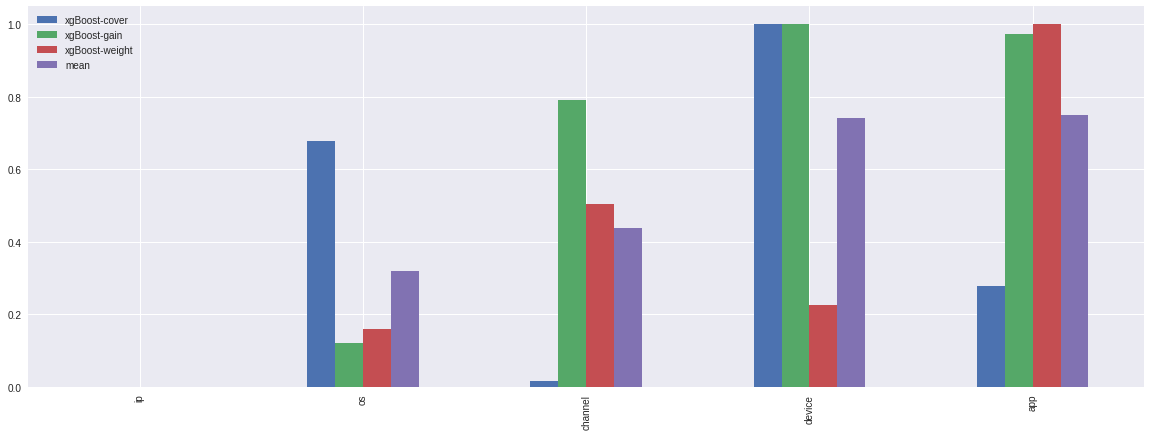

In [0]:


# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf0.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))

(1500000, 12) (500000, 12) (1500000,) (500000,)
AUC: 91.88%


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


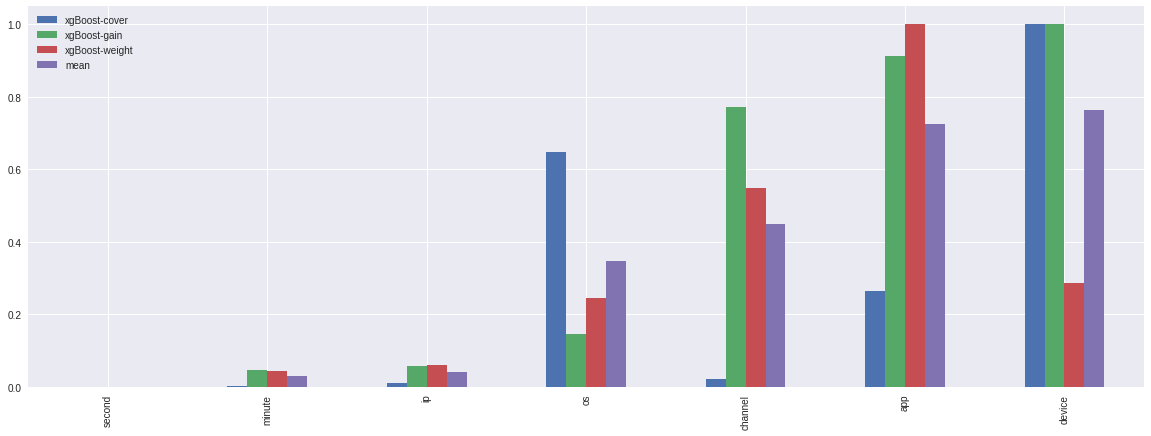

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train[features1], train[target], test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

clf1 = XGBClassifier()
clf1.fit(X_train, y_train)

prd1 = clf1.predict_proba(X_test)

roc1 = metrics.roc_auc_score(y_test, prd1[:, 1])
print("AUC: %.2f%%" % (roc1 * 100.0))

from sklearn import preprocessing

# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf1.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))

In [0]:
print(importance_df.head(12))

         xgBoost-cover  xgBoost-gain  xgBoost-weight      mean
app           0.264566      0.911480        1.000000  0.725349
channel       0.021804      0.772934        0.549020  0.447919
device        1.000000      1.000000        0.287582  0.762527
ip            0.009544      0.057216        0.058824  0.041861
minute        0.002906      0.046679        0.042484  0.030690
os            0.647030      0.145654        0.245098  0.345927
second        0.000000      0.000000        0.000000  0.000000


(1500000, 14) (500000, 14) (1500000,) (500000,)
AUC: 94.10%


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


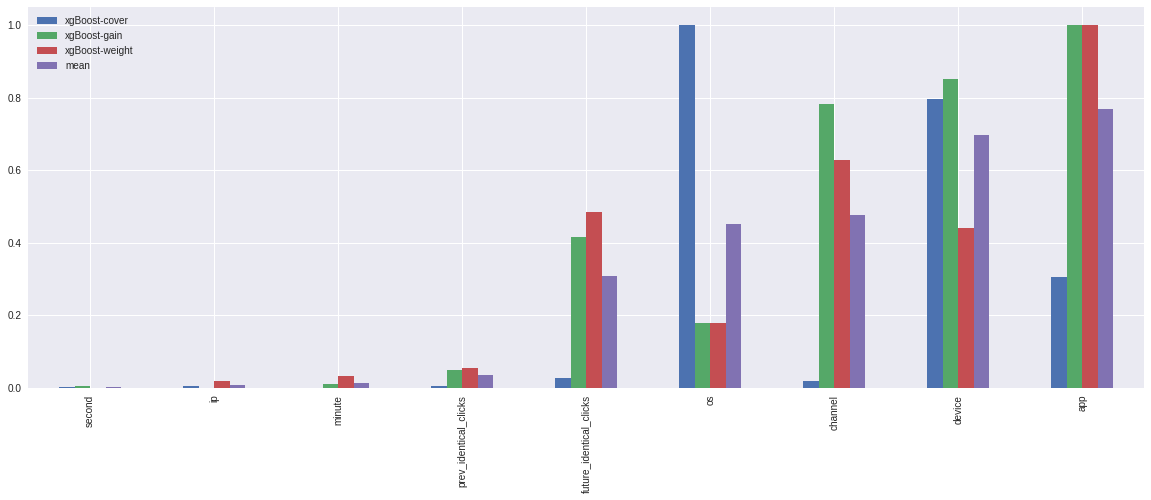

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train[features2], train[target], test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
clf2 = XGBClassifier()
clf2.fit(X_train, y_train)

prd2 = clf2.predict_proba(X_test)

roc2 = metrics.roc_auc_score(y_test, prd2[:, 1])
print("AUC: %.2f%%" % (roc2 * 100.0))

from sklearn import preprocessing

# Get xgBoost importances
importance_dict2 = {}
for import_type2 in ['weight', 'gain', 'cover']:
    importance_dict2['xgBoost-'+import_type2] = clf2.get_booster().get_score(importance_type=import_type2)
    
# MinMax scale all importances
importance_df2 = pd.DataFrame(importance_dict2).fillna(0)
importance_df2 = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df2),
    columns=importance_df2.columns,
    index=importance_df2.index
)

# Create mean column
importance_df2['mean'] = importance_df2.mean(axis=1)

# Plot the feature importances
importance_df2.sort_values('mean').plot(kind='bar', figsize=(20, 7))

In [0]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[features3], train[target], test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

clf3 = XGBClassifier()
clf3.fit(X_train, y_train)

prd3 = clf3.predict_proba(X_test)

roc3 = metrics.roc_auc_score(y_test, prd3[:, 1])
print("AUC: %.2f%%" % (roc3 * 100.0))

from sklearn import preprocessing

(1500000, 33) (500000, 33) (1500000,) (500000,)
AUC: 96.19%


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


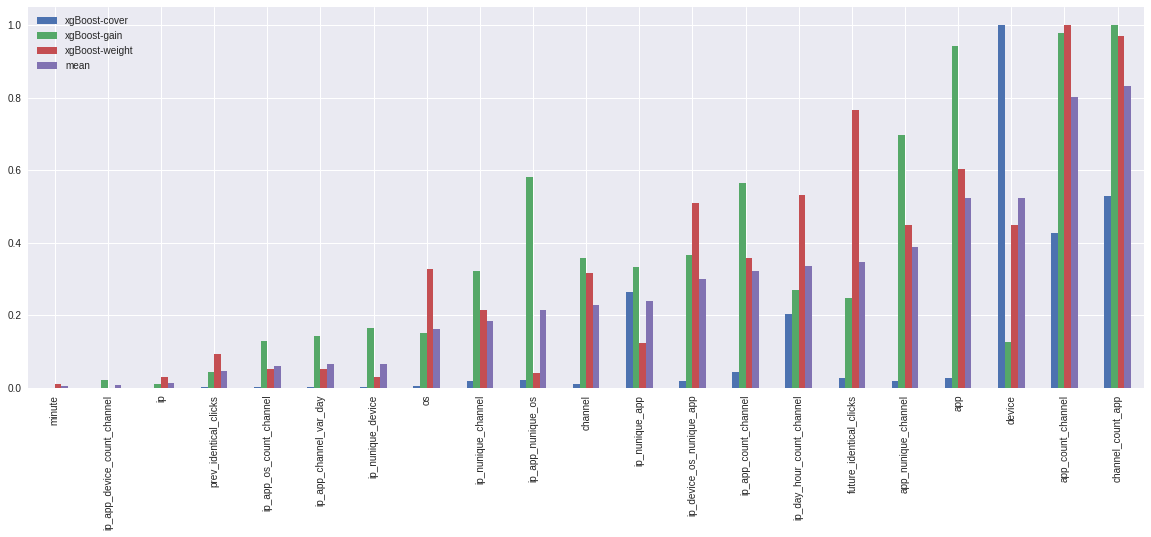

In [0]:
# Get xgBoost importances
importance_dict3 = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict3['xgBoost-'+import_type] = clf3.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df3 = pd.DataFrame(importance_dict3).fillna(0)
importance_df3 = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df3),
    columns=importance_df3.columns,
    index=importance_df3.index
)

# Create mean column
importance_df3['mean'] = importance_df3.mean(axis=1)

# Plot the feature importances
importance_df3.sort_values('mean').plot(kind='bar', figsize=(20, 7))

In [0]:
print(importance_df['xgBoost-gain'].head(33).sort_values(ascending=False))

channel_count_app              1.000000
app_count_channel              0.978427
app                            0.943563
app_nunique_channel            0.697268
ip_app_nunique_os              0.582294
ip_app_count_channel           0.563835
ip_device_os_nunique_app       0.367183
channel                        0.356478
ip_nunique_app                 0.333539
ip_nunique_channel             0.322032
ip_day_hour_count_channel      0.269368
future_identical_clicks        0.248311
ip_nunique_device              0.165278
os                             0.151844
ip_app_channel_var_day         0.141751
ip_app_os_count_channel        0.128629
device                         0.124900
prev_identical_clicks          0.042619
ip_app_device_count_channel    0.022053
ip                             0.011286
minute                         0.000000
Name: xgBoost-gain, dtype: float64


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Data columns (total 39 columns):
ip                                      uint32
app                                     uint16
device                                  uint16
os                                      uint16
channel                                 uint16
click_time                              datetime64[ns]
is_attributed                           uint8
hour                                    uint16
minute                                  uint16
second                                  uint16
day                                     uint16
weekday                                 uint16
dayofyear                               uint16
month                                   uint16
prev_identical_clicks                   int64
future_identical_clicks                 int64
ip_app_count_channel                    uint16
ip_app_os_count_channel                 uint16
ip_app_device_count_channel         

In [0]:
xgbf = ['channel_count_app',
'app_count_channel',
'app',                           
'app_nunique_channel',          
'ip_app_nunique_os',         
'ip_app_count_channel',        
'ip_device_os_nunique_app',     
'channel',                      
'ip_nunique_app',                
'ip_nunique_channel']

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f56a1a175f8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


In [0]:
X_train, X_test, y_train, y_test = train_test_split(train[xgbf], train[target], test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1500000, 10) (500000, 10) (1500000,) (500000,)


In [0]:
xgbm = XGBClassifier()
xgbm.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
# make predictions for test data
# use predict_proba to compute auc
y_pred = xgbm.predict_proba(X_test)
y_pred[:10]

array([[9.9946696e-01, 5.3305784e-04],
       [9.9970084e-01, 2.9914256e-04],
       [9.9952924e-01, 4.7076671e-04],
       [9.9969286e-01, 3.0714160e-04],
       [9.9934763e-01, 6.5239670e-04],
       [9.9958146e-01, 4.1853305e-04],
       [9.9976659e-01, 2.3338718e-04],
       [9.9966824e-01, 3.3173437e-04],
       [9.9976945e-01, 2.3057662e-04],
       [9.9928671e-01, 7.1328739e-04]], dtype=float32)

In [0]:
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 94.69%


Use feature all features have better accuracy.

### 3.1.2 Hyperparameter tuning

In [0]:
fxgbfeatures = ['ip',
 'app',
 'device',
 'os',
 'channel',
 'hour',
 'minute',
 'second',
 'day',
 'weekday',
 'dayofyear',
 'month',
 'prev_identical_clicks',
 'future_identical_clicks',
 'ip_app_count_channel',
 'ip_app_os_count_channel',
 'ip_app_device_count_channel',
 'ip_day_hour_count_channel',
 'ip_app_day_hour_count_channel',
 'ip_app_device_day_hour_count_channel',
 'app_count_channel',
 'channel_count_app',
 'ip_app_channel_var_day',
 'ip_app_device_var_day',
 'ip_app_os_var_day',
 'ip_app_channel_mean_hour',
 'ip_nunique_channel',
 'ip_nunique_app',
 'ip_day_nunique_hour',
 'ip_app_nunique_os',
 'ip_nunique_device',
 'app_nunique_channel',
 'ip_device_os_nunique_app']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train[fxgbfeatures], train[target], test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1500000, 33) (500000, 33) (1500000,) (500000,)


In [0]:
xgbm1 = XGBClassifier()
xgbm1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
# make predictions for test data
# use predict_proba to compute auc
y_pred = xgbm1.predict_proba(X_test)
y_pred[:10]

array([[9.9973989e-01, 2.6009639e-04],
       [9.9960452e-01, 3.9545001e-04],
       [9.9919367e-01, 8.0631563e-04],
       [9.9949706e-01, 5.0293707e-04],
       [9.9925953e-01, 7.4043928e-04],
       [9.9974740e-01, 2.5258641e-04],
       [9.9945229e-01, 5.4768333e-04],
       [9.9939221e-01, 6.0781115e-04],
       [9.9963999e-01, 3.6001968e-04],
       [9.9924231e-01, 7.5770909e-04]], dtype=float32)

In [0]:
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 96.19%


In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
loops = 3

# range of hyperparameters
param_grid = {'learning_rate' : [0.1, 0.3],
             'subsample': [0.3, 0.6, 0.9]}

# model
xgb_model1 = XGBClassifier(max_depth = 2, n_estimators = 200)

# GridSearchCV()

xmodel_cv1 = GridSearchCV(estimator = xgb_model1, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = loops, 
                        verbose = 1,
                        return_train_score=True)

In [0]:
# fit the model
xmodel_cv1.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 93.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.1, 0.3], 'subsample': [0.3, 0.6, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [0]:
# results
cvr1 = pd.DataFrame(xmodel_cv1.cv_results_)
cvr1

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,297.644657,2.752982,0.952831,0.959675,0.1,0.3,"{'learning_rate': 0.1, 'subsample': 0.3}",6,0.951004,0.961055,0.957723,0.959708,0.949766,0.958262,7.477463,0.117932,0.003496,0.001140
1,314.863816,2.560696,0.954355,0.959882,0.1,0.6,"{'learning_rate': 0.1, 'subsample': 0.6}",3,0.953545,0.960610,0.959033,0.959785,0.950486,0.959253,5.264751,0.028851,0.003536,0.000559
2,306.597335,2.549095,0.954065,0.960338,0.1,0.9,"{'learning_rate': 0.1, 'subsample': 0.9}",4,0.953777,0.960402,0.959182,0.960082,0.949236,0.960531,1.962858,0.081718,0.004065,0.000189
3,285.473680,2.942222,0.953442,0.968321,0.3,0.3,"{'learning_rate': 0.3, 'subsample': 0.3}",5,0.950780,0.968933,0.956102,0.969253,0.953443,0.966777,7.469705,0.098745,0.002173,0.001100
4,316.372699,2.892806,0.957192,0.971335,0.3,0.6,"{'learning_rate': 0.3, 'subsample': 0.6}",2,0.956384,0.971270,0.958970,0.971497,0.956221,0.971238,1.797320,0.041481,0.001259,0.000115
5,292.199527,2.896303,0.957245,0.971691,0.3,0.9,"{'learning_rate': 0.3, 'subsample': 0.9}",1,0.955203,0.972845,0.961336,0.971455,0.955195,0.970774,13.033800,0.031431,0.002893,0.000862


In [0]:
# convert parameters to int for plotting on x-axis
cvr1['param_learning_rate'] = cvr1['param_learning_rate'].astype('float')
#cvr1['param_max_depth'] = cvr1['param_max_depth'].astype('float')
cvr1.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,297.644657,2.752982,0.952831,0.959675,0.1,0.3,"{'learning_rate': 0.1, 'subsample': 0.3}",6,0.951004,0.961055,0.957723,0.959708,0.949766,0.958262,7.477463,0.117932,0.003496,0.001140
1,314.863816,2.560696,0.954355,0.959882,0.1,0.6,"{'learning_rate': 0.1, 'subsample': 0.6}",3,0.953545,0.960610,0.959033,0.959785,0.950486,0.959253,5.264751,0.028851,0.003536,0.000559
2,306.597335,2.549095,0.954065,0.960338,0.1,0.9,"{'learning_rate': 0.1, 'subsample': 0.9}",4,0.953777,0.960402,0.959182,0.960082,0.949236,0.960531,1.962858,0.081718,0.004065,0.000189
3,285.473680,2.942222,0.953442,0.968321,0.3,0.3,"{'learning_rate': 0.3, 'subsample': 0.3}",5,0.950780,0.968933,0.956102,0.969253,0.953443,0.966777,7.469705,0.098745,0.002173,0.001100
4,316.372699,2.892806,0.957192,0.971335,0.3,0.6,"{'learning_rate': 0.3, 'subsample': 0.6}",2,0.956384,0.971270,0.958970,0.971497,0.956221,0.971238,1.797320,0.041481,0.001259,0.000115


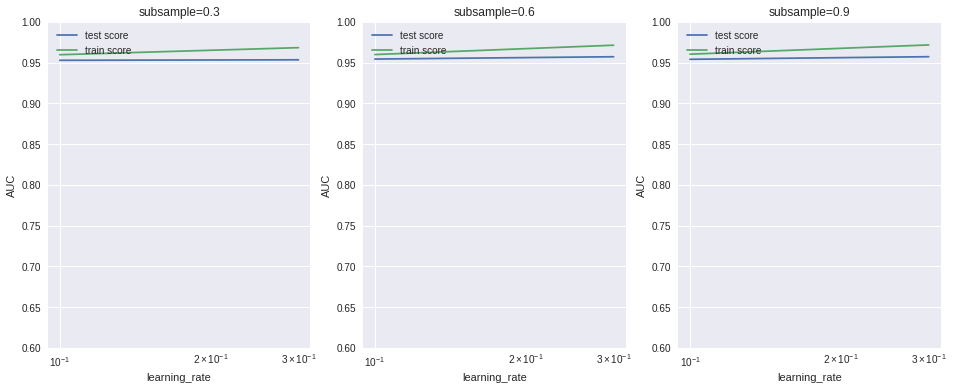

In [0]:
# plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.1, 0.3], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cvr1[cvr1['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [0]:

# fit model on training data
xmodel2 = XGBClassifier(
          learning_rate = 0.1,
          max_depth = 2, 
          n_estimators=200,
          subsample=0.6,
          objective='binary:logistic')
xmodel2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

In [0]:
# predict
y_pred2 = xmodel2.predict_proba(X_test)
roc2 = metrics.roc_auc_score(y_test, y_pred2[:, 1])
print("AUC: %.2f%%" % (roc2 * 100.0))

AUC: 96.26%


In [0]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(train[features3], train[target], test_size=0.25, random_state=42)
# fit model on training data
xmodel3 = XGBClassifier(
          learning_rate = 0.1,
          max_depth = 4, 
          n_estimators=200,
          subsample=0.6,
          reg_alpha = 4,
          n_jobs = 4,
          objective='binary:logistic')
xmodel3.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=4, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

In [0]:
# predict
from sklearn import metrics
y_pred3 = xmodel3.predict_proba(X_test)
roc3 = metrics.roc_auc_score(y_test, y_pred3[:, 1])
print("AUC: %.2f%%" % (roc3 * 100.0))

AUC: 96.74%


In [0]:
xmodel3.fit(X_train, y_train, 
            eval_set=[(X_train, y_train),(X_test,y_test)],
           eval_metric='auc',
           early_stopping_rounds = 100)

NameError: ignored

In [0]:
# fit model on training data
xmodel4 = XGBClassifier(
          learning_rate = 0.1,
          max_depth = 4, 
          n_estimators=200,
          subsample=0.6,
          reg_alpha = 4,
          n_jobs = 4,
          colsample_bytree=0.7,
          colsample_bylevel=0.7,
          scale_pos_weight=9,
          objective='binary:logistic')
xmodel4.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=4, reg_lambda=1, scale_pos_weight=9, seed=None,
       silent=True, subsample=0.6)

In [0]:
# predict
y_pred4 = xmodel4.predict_proba(X_test)
roc4 = metrics.roc_auc_score(y_test, y_pred4[:, 1])
print("AUC: %.2f%%" % (roc4 * 100.0))

AUC: 96.64%


Best model is hyperparameter with {learning_rate = 0.1,
          max_depth = 4, 
          n_estimators=200,
          subsample=0.6,
          reg_alpha = 4,
          n_jobs = 4,
          objective='binary:logistic'}. AUC is 96.74%.

##3.2 LightGBM


###3.2.1 

In [0]:
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train[features0], train[target], test_size=0.25, random_state=42)

In [0]:
clfl0 = LGBMClassifier()

eval_set = [(X_train, y_train), (X_test, y_test)]
clfl0.fit(X_train, y_train, eval_metric='auc', eval_set = eval_set)

[1]	training's binary_logloss: 0.0241407	training's auc: 0.855326	valid_1's binary_logloss: 0.0237427	valid_1's auc: 0.860629
[2]	training's binary_logloss: 0.0271433	training's auc: 0.537573	valid_1's binary_logloss: 0.0248064	valid_1's auc: 0.554217
[3]	training's binary_logloss: 0.0433725	training's auc: 0.554519	valid_1's binary_logloss: 0.0430363	valid_1's auc: 0.56568
[4]	training's binary_logloss: 0.0391328	training's auc: 0.396067	valid_1's binary_logloss: 0.0361418	valid_1's auc: 0.412127
[5]	training's binary_logloss: 0.0393926	training's auc: 0.397127	valid_1's binary_logloss: 0.0365514	valid_1's auc: 0.41428
[6]	training's binary_logloss: 0.0352931	training's auc: 0.512897	valid_1's binary_logloss: 0.0321932	valid_1's auc: 0.539523
[7]	training's binary_logloss: 0.0689652	training's auc: 0.70321	valid_1's binary_logloss: 0.0700282	valid_1's auc: 0.732852
[8]	training's binary_logloss: 0.0586459	training's auc: 0.602394	valid_1's binary_logloss: 0.0575643	valid_1's auc: 0.61

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


prd0 = clfl0.predict(X_test)
prdprob0 = clfl0.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd0)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob0[:, 1])))



Accuracy:  0.997858
AUC(train):  0.5115259766055624


In [0]:
clfl0.fit(X_train, y_train, eval_metric='auc', eval_set = eval_set, early_stopping_rounds=100)
prd0 = clfl0.predict(X_test)
prdprob0 = clfl0.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd0)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob0[:, 1])))

[1]	valid_0's binary_logloss: 0.0241407	valid_0's auc: 0.855326	valid_1's binary_logloss: 0.0237427	valid_1's auc: 0.860629
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.0271433	valid_0's auc: 0.537573	valid_1's binary_logloss: 0.0248064	valid_1's auc: 0.554217
[3]	valid_0's binary_logloss: 0.0433725	valid_0's auc: 0.554519	valid_1's binary_logloss: 0.0430363	valid_1's auc: 0.56568
[4]	valid_0's binary_logloss: 0.0391328	valid_0's auc: 0.396067	valid_1's binary_logloss: 0.0361418	valid_1's auc: 0.412127
[5]	valid_0's binary_logloss: 0.0393926	valid_0's auc: 0.397127	valid_1's binary_logloss: 0.0365514	valid_1's auc: 0.41428
[6]	valid_0's binary_logloss: 0.0352931	valid_0's auc: 0.512897	valid_1's binary_logloss: 0.0321932	valid_1's auc: 0.539523
[7]	valid_0's binary_logloss: 0.0689652	valid_0's auc: 0.70321	valid_1's binary_logloss: 0.0700282	valid_1's auc: 0.732852
[8]	valid_0's binary_logloss: 0.0586459	valid_0's auc: 0.602394	valid_1'

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train[features1], train[target], test_size=0.25, random_state=42)

clfl1 = LGBMClassifier()

#eval_set = [(X_train, y_train), (X_test, y_test)]
clfl1.fit(X_train, y_train)

prd1 = clfl1.predict(X_test)
prdprob1 = clfl1.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd1)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob1[:, 1])))

Accuracy:  0.998014
AUC(train):  0.5792869999273367


In [0]:
eval_set = [(X_train, y_train), (X_test, y_test)]
clfl1.fit(X_train, y_train, eval_metric='auc', eval_set = eval_set, early_stopping_rounds=100)
prd1 = clfl1.predict(X_test)
prdprob1 = clfl1.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd1)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob1[:, 1])))

[1]	training's binary_logloss: 0.0239613	training's auc: 0.85533	valid_1's binary_logloss: 0.0235998	valid_1's auc: 0.86064
Training until validation scores don't improve for 100 rounds.
[2]	training's binary_logloss: 0.0263313	training's auc: 0.560417	valid_1's binary_logloss: 0.0242213	valid_1's auc: 0.571135
[3]	training's binary_logloss: 0.0410684	training's auc: 0.577942	valid_1's binary_logloss: 0.0413899	valid_1's auc: 0.587028
[4]	training's binary_logloss: 0.0361558	training's auc: 0.543285	valid_1's binary_logloss: 0.0356277	valid_1's auc: 0.54857
[5]	training's binary_logloss: 0.0413037	training's auc: 0.534027	valid_1's binary_logloss: 0.0409897	valid_1's auc: 0.549834
[6]	training's binary_logloss: 0.040782	training's auc: 0.526994	valid_1's binary_logloss: 0.040755	valid_1's auc: 0.543249
[7]	training's binary_logloss: 0.0394156	training's auc: 0.513591	valid_1's binary_logloss: 0.0377514	valid_1's auc: 0.536239
[8]	training's binary_logloss: 0.0403208	training's auc: 0.5

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train[features2], train[target], test_size=0.25, random_state=42)

clfl2 = LGBMClassifier()

#eval_set = [(X_train, y_train), (X_test, y_test)]
clfl2.fit(X_train, y_train)

prd2 = clfl2.predict(X_test)
prdprob2 = clfl2.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd2)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob2[:, 1])))

Accuracy:  0.99791
AUC(train):  0.6345771946245082


In [0]:
eval_set = [(X_train, y_train), (X_test, y_test)]
clfl2.fit(X_train, y_train, eval_metric='auc', eval_set = eval_set, early_stopping_rounds=100)
prd2 = clfl2.predict(X_test)
prdprob2 = clfl2.predict_proba(X_test)

print("Accuracy: " , (metrics.accuracy_score(y_test, prd2)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob2[:, 1])))

[1]	training's binary_logloss: 0.0242176	training's auc: 0.855403	valid_1's binary_logloss: 0.024683	valid_1's auc: 0.862011
Training until validation scores don't improve for 100 rounds.
[2]	training's binary_logloss: 0.0282753	training's auc: 0.590818	valid_1's binary_logloss: 0.0273095	valid_1's auc: 0.596828
[3]	training's binary_logloss: 0.0320343	training's auc: 0.435797	valid_1's binary_logloss: 0.0306936	valid_1's auc: 0.452386
[4]	training's binary_logloss: 0.0301205	training's auc: 0.550233	valid_1's binary_logloss: 0.0296422	valid_1's auc: 0.549095
[5]	training's binary_logloss: 0.0481373	training's auc: 0.7681	valid_1's binary_logloss: 0.0516145	valid_1's auc: 0.768222
[6]	training's binary_logloss: 0.0456649	training's auc: 0.716106	valid_1's binary_logloss: 0.0480504	valid_1's auc: 0.712703
[7]	training's binary_logloss: 0.0455302	training's auc: 0.724164	valid_1's binary_logloss: 0.0481526	valid_1's auc: 0.71842
[8]	training's binary_logloss: 0.0437533	training's auc: 0.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train[features3], train[target], test_size=0.25, random_state=42)

clfl3 = LGBMClassifier()

#eval_set = [(X_train, y_train), (X_test, y_test)]
clfl3.fit(X_train, y_train)

prd3 = clfl3.predict(X_test)
prdprob3 = clfl3.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd3)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob3[:, 1])))

Accuracy:  0.998012
AUC(train):  0.7355036926096925


In [0]:
eval_set = [(X_train, y_train), (X_test, y_test)]

clfl3.fit(X_train, y_train, eval_metric='auc', eval_set = eval_set, early_stopping_rounds=100)
prd3 = clfl3.predict(X_test)
prdprob3 = clfl3.predict_proba(X_test)

print("Accuracy: " , (metrics.accuracy_score(y_test, prd3)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob3[:, 1])))

[1]	training's binary_logloss: 0.0195352	training's auc: 0.872753	valid_1's binary_logloss: 0.0178204	valid_1's auc: 0.875659
Training until validation scores don't improve for 100 rounds.
[2]	training's binary_logloss: 0.0210617	training's auc: 0.73232	valid_1's binary_logloss: 0.0193656	valid_1's auc: 0.735194
[3]	training's binary_logloss: 0.0228719	training's auc: 0.715162	valid_1's binary_logloss: 0.0217259	valid_1's auc: 0.725374
[4]	training's binary_logloss: 0.0238238	training's auc: 0.723852	valid_1's binary_logloss: 0.0225674	valid_1's auc: 0.738257
[5]	training's binary_logloss: 0.0264101	training's auc: 0.671211	valid_1's binary_logloss: 0.0269395	valid_1's auc: 0.652351
[6]	training's binary_logloss: 0.0244417	training's auc: 0.696954	valid_1's binary_logloss: 0.0246054	valid_1's auc: 0.687471
[7]	training's binary_logloss: 0.0304989	training's auc: 0.726557	valid_1's binary_logloss: 0.0294938	valid_1's auc: 0.718656
[8]	training's binary_logloss: 0.0298776	training's auc:

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
kf = 3

# range of hyperparameters
param_grid = {'learning_rate' : [0.1, 0.3],
             'subsample': [0.3, 0.6, 0.9]}

# model
clfl4 = LGBMClassifier(max_depth = 2, n_estimators = 200)

# GridSearchCV()

clfl_cv4 = GridSearchCV(estimator = clfl4, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = kf, 
                        verbose = 1,
                        return_train_score=True)

In [0]:
# fit the model
clfl_cv4.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  7.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=2,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.1, 0.3], 'subsample': [0.3, 0.6, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [0]:
cvrl = pd.DataFrame(clfl_cv4.cv_results_)
cvrl

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,20.018202,2.491552,0.917406,0.923568,0.1,0.3,"{'learning_rate': 0.1, 'subsample': 0.3}",1,0.953066,0.959811,0.861107,0.859701,0.938045,0.951192,0.166112,0.023249,0.040279,0.045298
1,20.020492,2.579681,0.917406,0.923568,0.1,0.6,"{'learning_rate': 0.1, 'subsample': 0.6}",1,0.953066,0.959811,0.861107,0.859701,0.938045,0.951192,0.172898,0.167644,0.040279,0.045298
2,19.945684,2.539719,0.917406,0.923568,0.1,0.9,"{'learning_rate': 0.1, 'subsample': 0.9}",1,0.953066,0.959811,0.861107,0.859701,0.938045,0.951192,0.235381,0.059224,0.040279,0.045298
3,18.068358,1.594758,0.467552,0.470432,0.3,0.3,"{'learning_rate': 0.3, 'subsample': 0.3}",4,0.420896,0.423249,0.498093,0.498973,0.483668,0.489074,0.981123,0.679847,0.033513,0.033607
4,18.121575,1.672605,0.467552,0.470432,0.3,0.6,"{'learning_rate': 0.3, 'subsample': 0.6}",4,0.420896,0.423249,0.498093,0.498973,0.483668,0.489074,0.971178,0.724035,0.033513,0.033607
5,18.157304,1.564960,0.467552,0.470432,0.3,0.9,"{'learning_rate': 0.3, 'subsample': 0.9}",4,0.420896,0.423249,0.498093,0.498973,0.483668,0.489074,0.953684,0.659543,0.033513,0.033607


In [0]:
cvrl['param_learning_rate'] = cvrl['param_learning_rate'].astype('float')
#cvr1['param_max_depth'] = cvr1['param_max_depth'].astype('float')
cvrl.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,20.018202,2.491552,0.917406,0.923568,0.1,0.3,"{'learning_rate': 0.1, 'subsample': 0.3}",1,0.953066,0.959811,0.861107,0.859701,0.938045,0.951192,0.166112,0.023249,0.040279,0.045298
1,20.020492,2.579681,0.917406,0.923568,0.1,0.6,"{'learning_rate': 0.1, 'subsample': 0.6}",1,0.953066,0.959811,0.861107,0.859701,0.938045,0.951192,0.172898,0.167644,0.040279,0.045298
2,19.945684,2.539719,0.917406,0.923568,0.1,0.9,"{'learning_rate': 0.1, 'subsample': 0.9}",1,0.953066,0.959811,0.861107,0.859701,0.938045,0.951192,0.235381,0.059224,0.040279,0.045298
3,18.068358,1.594758,0.467552,0.470432,0.3,0.3,"{'learning_rate': 0.3, 'subsample': 0.3}",4,0.420896,0.423249,0.498093,0.498973,0.483668,0.489074,0.981123,0.679847,0.033513,0.033607
4,18.121575,1.672605,0.467552,0.470432,0.3,0.6,"{'learning_rate': 0.3, 'subsample': 0.6}",4,0.420896,0.423249,0.498093,0.498973,0.483668,0.489074,0.971178,0.724035,0.033513,0.033607


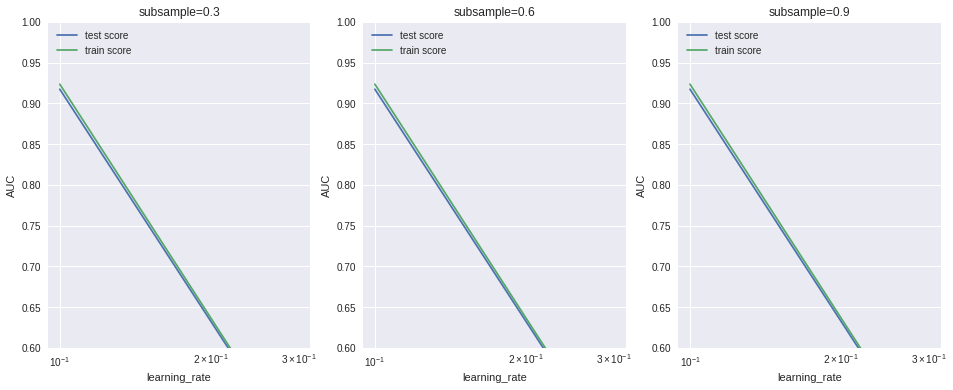

In [0]:
# plotting
plt.figure(figsize=(16,6))


param_grid = {'learning_rate': [0.1, 0.3], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cvrl[cvrl['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [0]:

clfl5 = LGBMClassifier(
        boosting_type='gbdt', 
        max_depth=2, 
        learning_rate=0.1, 
        n_estimators=200, 
        subsample=0.6,
        objective = 'binary',
        metric = 'auc'
        )

clfl5.fit(X_train, y_train)

prd5 = clfl5.predict(X_test)
prdprob5 = clfl5.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd5)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob5[:, 1])))

Accuracy:  0.998674
AUC(train):  0.9593011321492771


In [0]:
eval_set = [(X_train, y_train), (X_test, y_test)]

clfl5.fit(X_train, y_train, eval_metric='auc', eval_set = eval_set, early_stopping_rounds=100)
prd5 = clfl5.predict(X_test)
prdprob5 = clfl5.predict_proba(X_test)

print("Accuracy: " , (metrics.accuracy_score(y_test, prd5)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob5[:, 1])))

[1]	training's auc: 0.678697	valid_1's auc: 0.696711
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.847998	valid_1's auc: 0.855827
[3]	training's auc: 0.906358	valid_1's auc: 0.918534
[4]	training's auc: 0.910068	valid_1's auc: 0.921746
[5]	training's auc: 0.91713	valid_1's auc: 0.927511
[6]	training's auc: 0.917661	valid_1's auc: 0.928635
[7]	training's auc: 0.917051	valid_1's auc: 0.927322
[8]	training's auc: 0.926956	valid_1's auc: 0.934318
[9]	training's auc: 0.926183	valid_1's auc: 0.935417
[10]	training's auc: 0.929311	valid_1's auc: 0.937157
[11]	training's auc: 0.929781	valid_1's auc: 0.937402
[12]	training's auc: 0.93002	valid_1's auc: 0.937681
[13]	training's auc: 0.929577	valid_1's auc: 0.937928
[14]	training's auc: 0.930826	valid_1's auc: 0.938434
[15]	training's auc: 0.930914	valid_1's auc: 0.938295
[16]	training's auc: 0.932088	valid_1's auc: 0.939322
[17]	training's auc: 0.931856	valid_1's auc: 0.939366
[18]	training's auc: 0.932488	

In [0]:
clfl6 = LGBMClassifier(
        boosting_type='gbdt', 
        max_depth=4, 
        learning_rate=0.1, 
        n_estimators=200, 
        subsample=0.6,
        objective = 'binary',
        metric = 'auc'
        )

clfl6.fit(X_train, y_train)

prd6 = clfl6.predict(X_test)
prdprob6 = clfl6.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd6)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob6[:, 1])))

Accuracy:  0.998554
AUC(train):  0.9029811311079493


In [0]:

clfl7 = LGBMClassifier(
        boosting_type='gbdt', 
        max_depth=2, 
        learning_rate=0.1, 
        n_estimators=200, 
        subsample=0.6,
        objective = 'binary',
        metric = 'auc',
        scale_pos_weight = 99.7 # to fix unbalanced training data
        )

clfl7.fit(X_train, y_train)

prd7 = clfl7.predict(X_test)
prdprob7 = clfl7.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd7)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob7[:, 1])))

Accuracy:  0.954556
AUC(train):  0.7958610681179283


In [0]:

clfl8 = LGBMClassifier(
        boosting_type='gbdt', 
        max_depth=4, 
        learning_rate=0.1, 
        n_estimators=200, 
        subsample=0.6,
        objective = 'binary',
        metric = 'auc',
        scale_pos_weight = 99.7 # to fix unbalanced training data
        )

clfl8.fit(X_train, y_train)

prd8 = clfl8.predict(X_test)
prdprob8 = clfl8.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd8)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob8[:, 1])))

Accuracy:  0.976922
AUC(train):  0.8500313553143347


In [0]:

clfl9 = LGBMClassifier(
        boosting_type='gbdt', 
        max_depth=2, 
        learning_rate=0.1, 
        n_estimators=200, 
        subsample=0.6,
        objective = 'binary',
        metric = 'auc',
        subsample_freq = 1,  # frequence of subsample, <=0 means no enable
        colsample_bytree = 0.7,  # Subsample ratio of columns when constructing each tree.
        min_child_weight = 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        min_split_gain = 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        scale_pos_weight = 99.7 # to fix unbalanced training data
        )

clfl9.fit(X_train, y_train)

prd9 = clfl9.predict(X_test)
prdprob9 = clfl9.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd9)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob9[:, 1])))

Accuracy:  0.988242
AUC(train):  0.9567070573567376


In [0]:

clfl10 = LGBMClassifier(
        boosting_type='gbdt', 
        max_depth=2, 
        learning_rate=0.1, 
        n_estimators=200, 
        subsample=0.6,
        objective = 'binary',
        metric = 'auc',
        num_leaves = 7,  # we should let it be smaller than 2^(max_depth)
        min_child_samples = 100,  # Minimum number of data need in a child(min_data_in_leaf)
        max_bin = 100,  # Number of bucketed bin for feature values
        subsample_freq = 1,  # frequence of subsample, <=0 means no enable
        colsample_bytree = 0.7,  # Subsample ratio of columns when constructing each tree.
        min_child_weight = 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        min_split_gain = 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        scale_pos_weight = 99.7 # to fix unbalanced training data
        )

clfl10.fit(X_train, y_train)

prd10 = clfl10.predict(X_test)
prdprob10 = clfl10.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd10)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob10[:, 1])))

Accuracy:  0.979796
AUC(train):  0.9194863280317029


In [0]:

clfl11 = LGBMClassifier(
        boosting_type='gbdt', 
        max_depth=2, 
        learning_rate=0.1, 
        n_estimators=200, 
        subsample=0.6,
        objective = 'binary',
        metric = 'auc',
        num_leaves = 7,  # we should let it be smaller than 2^(max_depth)
        min_child_samples = 100,  # Minimum number of data need in a child(min_data_in_leaf)
        max_bin = 100,  # Number of bucketed bin for feature values
        subsample_freq = 1,  # frequence of subsample, <=0 means no enable
        colsample_bytree = 0.7,  # Subsample ratio of columns when constructing each tree.
        min_child_weight = 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        min_split_gain = 0  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        #scale_pos_weight = 99.7 # to fix unbalanced training data
        )

clfl11.fit(X_train, y_train)

prd11 = clfl11.predict(X_test)
prdprob11 = clfl11.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd11)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob11[:, 1])))

Accuracy:  0.998614
AUC(train):  0.8841100485541918


In [0]:
clfl12 = LGBMClassifier(boosting_type='gbdt', 
                         num_leaves=31, 
                         max_depth=-1, 
                         learning_rate=0.1, 
                         n_estimators=100, 
                         subsample_for_bin=200000, 
                         objective='binary', 
                         class_weight=None, 
                         min_split_gain=0.0, 
                         min_child_weight=0.001, 
                         min_child_samples=20, 
                         subsample=0.6, 
                         subsample_freq=0, 
                         colsample_bytree=0.3, 
                         reg_alpha=0.0, 
                         reg_lambda=0.0, 
                         random_state=None, 
                         n_jobs=-1, 
                         silent=True)
                        
clfl12.fit(X_train, y_train)

prd12 = clfl12.predict(X_test)
prdprob12 = clfl12.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd12)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob12[:, 1])))

Accuracy:  0.997606
AUC(train):  0.7633151168562685


In [0]:
clfl13 = LGBMClassifier(boosting_type='gbdt', 
                         num_leaves=31, 
                         max_depth=3, 
                         learning_rate=0.1, 
                         n_estimators=200, 
                         objective='binary', 
                         min_split_gain=0.0, 
                         subsample=0.7, 
                         colsample_bytree=0.9, 
                         n_jobs=4, 
                         scale_pos_weight = 200)
                        
clfl13.fit(X_train, y_train)

prd13 = clfl13.predict(X_test)
prdprob13 = clfl13.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prd13)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob13[:, 1])))

Accuracy:  0.946608
AUC(train):  0.8931216618287909


In [0]:
eval_set = [(X_train, y_train), (X_test, y_test)]

clfl13.fit(X_train, y_train, eval_metric='auc', eval_set = eval_set, early_stopping_rounds=100)
prd14 = clfl13.predict(X_test)
prdprob14 = clfl3.predict_proba(X_test)

print("Accuracy: " , (metrics.accuracy_score(y_test, prd14)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdprob14[:, 1])))

[1]	training's binary_logloss: 1.12419	training's auc: 0.920254	valid_1's binary_logloss: 1.13094	valid_1's auc: 0.930547
Training until validation scores don't improve for 100 rounds.
[2]	training's binary_logloss: 0.721787	training's auc: 0.706785	valid_1's binary_logloss: 0.724976	valid_1's auc: 0.702469
[3]	training's binary_logloss: 0.679687	training's auc: 0.851782	valid_1's binary_logloss: 0.68205	valid_1's auc: 0.842815
[4]	training's binary_logloss: 0.656793	training's auc: 0.862799	valid_1's binary_logloss: 0.659187	valid_1's auc: 0.852261
[5]	training's binary_logloss: 0.606918	training's auc: 0.871938	valid_1's binary_logloss: 0.607872	valid_1's auc: 0.860268
[6]	training's binary_logloss: 1.37433	training's auc: 0.821068	valid_1's binary_logloss: 1.38701	valid_1's auc: 0.819635
[7]	training's binary_logloss: 0.546093	training's auc: 0.857834	valid_1's binary_logloss: 0.547652	valid_1's auc: 0.840953
[8]	training's binary_logloss: 0.549277	training's auc: 0.865015	valid_1's

###3.2.2

In [0]:
lf = [
'app',                           
'app_nunique_channel',          
'ip_app_nunique_os',         
'ip_app_count_channel',        
'ip_device_os_nunique_app',     
'channel',                      
'ip_nunique_app',                
'ip_nunique_channel',
'ip_day_hour_count_channel',
'future_identical_clicks',
'ip_nunique_device',
'os',
'ip_app_channel_var_day',
'ip_app_os_count_channel',
'device',
'prev_identical_clicks',
'ip_app_device_count_channel',
'ip']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train[lf], train[target], test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1500000, 18) (500000, 18) (1500000,) (500000,)


In [0]:

lm = LGBMClassifier(
        boosting_type='gbdt', 
        max_depth=2, 
        learning_rate=0.1, 
        n_estimators=200, 
        subsample=0.6,
        objective = 'binary',
        metric = 'auc'
        )

lm.fit(X_train, y_train)

prdlm = lm.predict(X_test)
prdproblm = lm.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prdlm)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdproblm[:, 1])))

Accuracy:  0.998692
AUC(train):  0.9569095293801467


In [0]:
lm1= LGBMClassifier(boosting_type='gbdt', 
                         num_leaves=31, 
                         max_depth=3, 
                         learning_rate=0.1, 
                         n_estimators=200, 
                         objective='binary', 
                         min_split_gain=0.0, 
                         subsample=0.7, 
                         colsample_bytree=0.9, 
                         n_jobs=4, 
                         scale_pos_weight = 200)
                        
lm1.fit(X_train, y_train)

prdlm1 = lm1.predict(X_test)
prdproblm1 = lm1.predict_proba(X_test)
print("Accuracy: " , (metrics.accuracy_score(y_test, prdlm1)))
print("AUC(train): " , (metrics.roc_auc_score(y_test, prdproblm1[:, 1])))

Accuracy:  0.936006
AUC(train):  0.7958818706043094


##Predictions on Test Data

In [0]:
def datetimefeatures(df):
  df['click_time'] = pd.to_datetime(df['click_time'])
  df['hour'] = df['click_time'].dt.hour.astype('uint16')
  df['minute'] = df['click_time'].dt.minute.astype('uint16')
  df['second'] = df['click_time'].dt.second.astype('uint16')
  df['day'] = df['click_time'].dt.day.astype('uint16')
  df['weekday'] = df['click_time'].dt.weekday.astype('uint16')
  df['dayofyear'] = df['click_time'].dt.dayofyear.astype('uint16')
  df['month'] = df['click_time'].dt.month.astype('uint16')
  return df


test = datetimefeatures(test)


In [0]:
test.drop(['click_time'], axis =1, inplace=True)

In [0]:
def clickhistory(df):
  click_history ={

      'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
      'app_clicks': ['ip', 'app']
  }

  for c, s in click_history.items():
     # Clicks in the past
      df['prev_'+c] = df. \
          groupby(s). \
          cumcount(). \
          rename('prev_'+c)

      # Clicks in the future
      df['future_'+c] = df.iloc[::-1]. \
          groupby(s). \
          cumcount(). \
          rename('future_'+c).iloc[::-1]
      return df
    
#train = clickhistory(train)
test = clickhistory(test)

print(test.shape)

(18790469, 15)


In [0]:
group = [
    # Count Features
    ############################################################
    
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count', 'type': 'uint16'},
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count', 'type': 'uint16'},
     # Count, for ip-app-device
    {'groupby': ['ip', 'app', 'device'], 'select': 'channel', 'agg': 'count', 'type': 'uint16'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count','type': 'uint16'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count', 'type': 'uint16'},
    # Count, for ip-app-device-day-hour
    {'groupby': ['ip','app', 'device', 'day','hour'], 'select': 'channel', 'agg': 'count', 'type': 'uint16'},
    # Popularity of app / channel 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count', 'type': 'uint16'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count', 'type': 'uint16'},
    ############################################################
    
    # Variance Features
    ############################################################
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var', 'type': 'float32'},
    # Variance in day, for ip-app-device
    {'groupby': ['ip','app','device'], 'select': 'day', 'agg': 'var', 'type': 'float32'},
    # Variance in day, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'day', 'agg': 'var', 'type': 'float32'},
    ############################################################
    
    # Mean Features
    ############################################################
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean', 'type': 'uint16'}, 
    ############################################################
    
    # Nunique Features
    ############################################################
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique', 'type': 'uint16'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique', 'type': 'uint16'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique', 'type': 'uint16'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique', 'type': 'uint16'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique', 'type': 'uint16'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique', 'type': 'uint16'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique', 'type': 'uint16'}, 
    ############################################################
    
    # Cumcount Features
    ############################################################
    #'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount', 'type': 'uint32'}, 
    #{'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount', 'type': 'uint32'}
    ############################################################
    
]

# Apply all the groupby transformations
for spec in group:
    print(f"Grouping by {spec['groupby']}, and aggregating {spec['select']} with {spec['agg']}")
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), spec['agg'], spec['select'])
    # Perform the groupby
    gp = train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature}).astype(spec['type'])
     # Merge back to X_train
    test = test.merge(gp, on=spec['groupby'], how='left')
    #test_df = test_df.mearge(gp, on=spec['groupby'], how='left')


print("End")

Grouping by ['ip', 'app'], and aggregating channel with count


NameError: ignored